In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path

In [2]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    ##r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt" # Hela dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

Interpolate the outlier in the transect from skagen to gbg, last day

In [3]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# flag outliers
bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

# interpolate the gaps
df_all = df_all.set_index('datetime')              # make time the index  
df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density

In [4]:
print(df_all.columns)

Index(['datetime', 'Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'source'],
      dtype='object')


In [5]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

In [6]:
print(df_all[['Temp_in_SBE38',
              'Salinity_SBE45',
              'pressure']].describe())
print(df_all[['Temp_in_SBE38',
              'Salinity_SBE45',
              'pressure']].min())


       Temp_in_SBE38  Salinity_SBE45    pressure
count     468.000000      468.000000  468.000000
mean       10.669580       25.419195  199.256709
std         0.312864        1.987368    4.871384
min         9.374091       20.841084  189.503333
25%        10.648101       24.064411  195.723472
50%        10.734561       25.033521  197.908776
75%        10.834021       26.001401  202.555320
max        11.134110       30.412489  222.921207
Temp_in_SBE38       9.374091
Salinity_SBE45     20.841084
pressure          189.503333
dtype: float64


In [7]:
print(df_all.columns)

Index(['datetime', 'Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'source', 'SA', 'CT', 'sigma0'],
      dtype='object')


In [8]:
print(CT.mean())

10.837638350065355


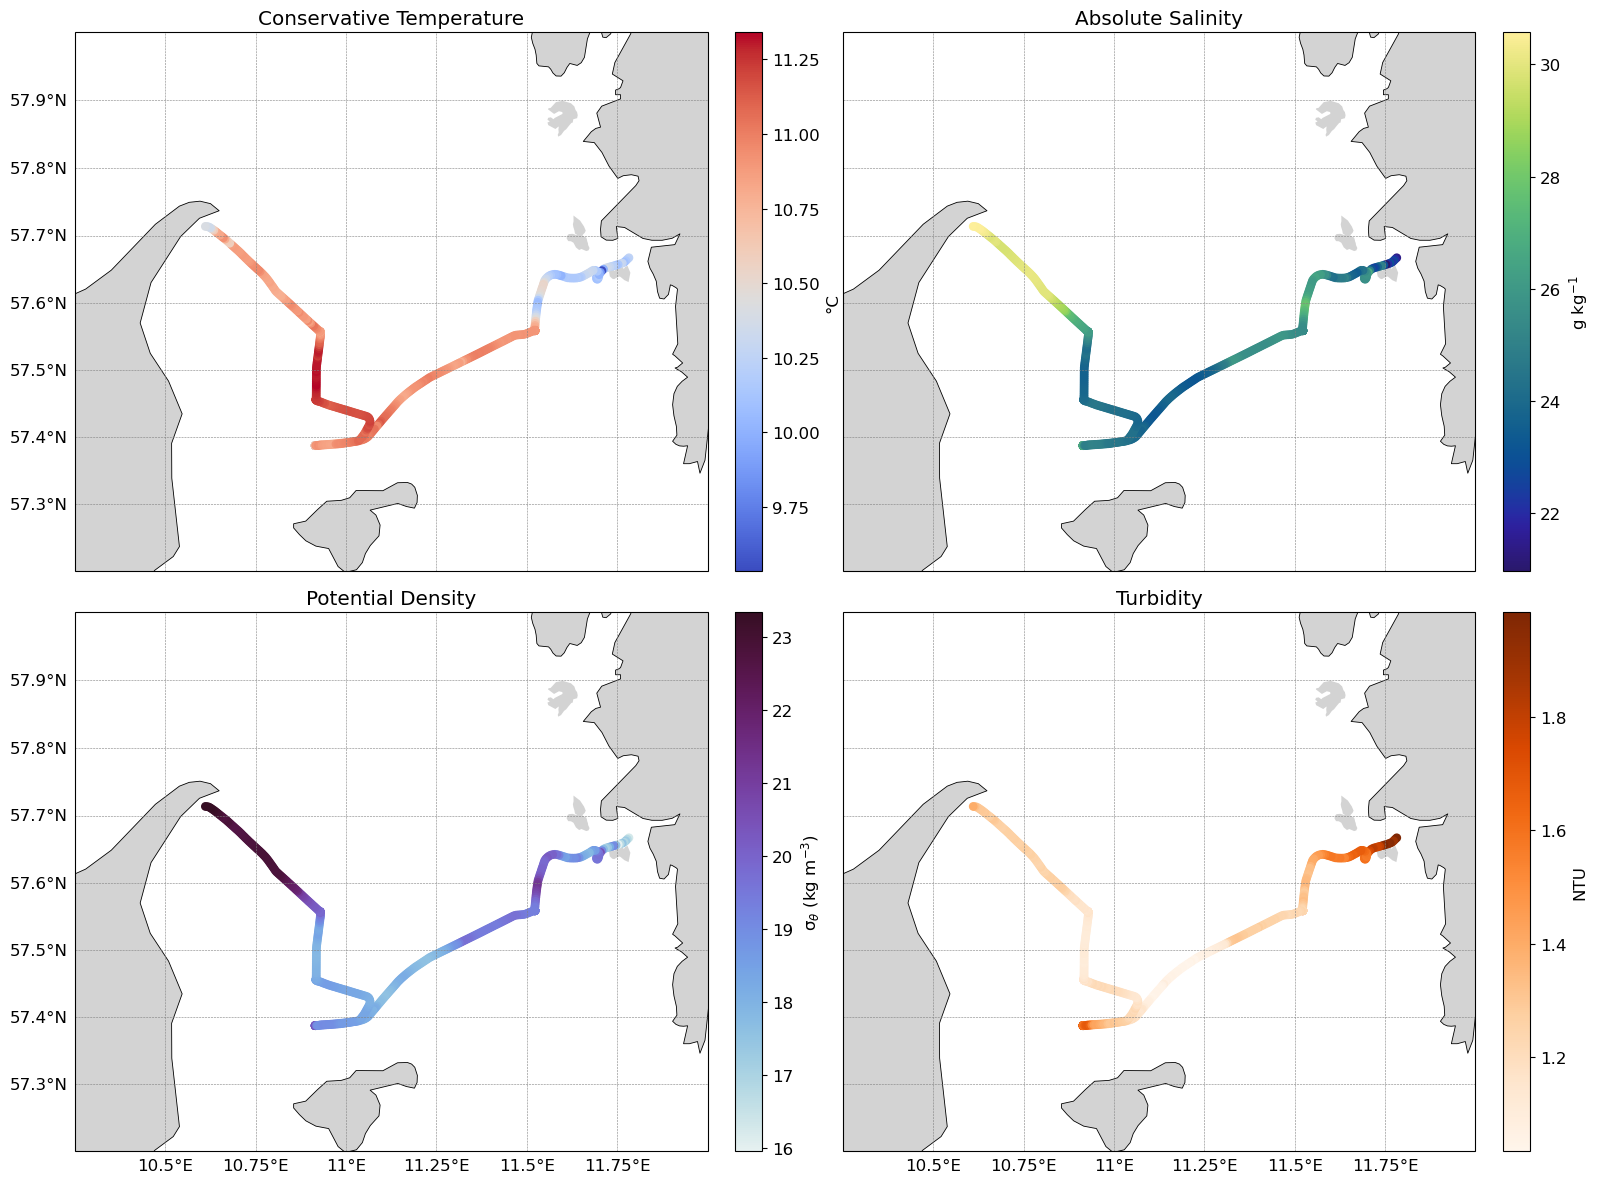

In [9]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})      # pick any base size you like


# Choose what variables to visualize

lon, lat = df_all["Longitude"], df_all["Latitude"]

variables = ["CT", "SA", "sigma0", "Turbidity"]
titles    = ["Conservative Temperature", "Absolute Salinity", "Potential Density", "Turbidity"]
cmaps     = ["coolwarm", "cmo.haline", "cmo.dense", "Oranges"]
cbar_titles  = ["°C", "g kg$^{-1}$", "σ$_\\theta$ (kg m$^{-3}$)", "NTU"]  

extent = [10.25, 12, 57.2, 58]

# 2 × 2 map panel
norms = {v: mpl.colors.Normalize(df_all[v].min(), df_all[v].max()) for v in variables}

fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                         subplot_kw={"projection": ccrs.Mercator()})
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.4)

    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
    gl.top_labels = gl.right_labels = False
    if i % 2:  gl.left_labels   = False
    if i < 2:  gl.bottom_labels = False

    sc = ax.scatter(lon, lat,
                    c=df_all[variables[i]],
                    cmap=cmaps[i],
                    norm=norms[variables[i]],
                    s=28,
                    transform=ccrs.PlateCarree())

    cbar = plt.colorbar(sc, ax=ax, orientation="vertical",
                        fraction=0.046, pad=0.04)
    cbar.set_label(cbar_titles[i]) 
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

Here is a way to control/check each variable:

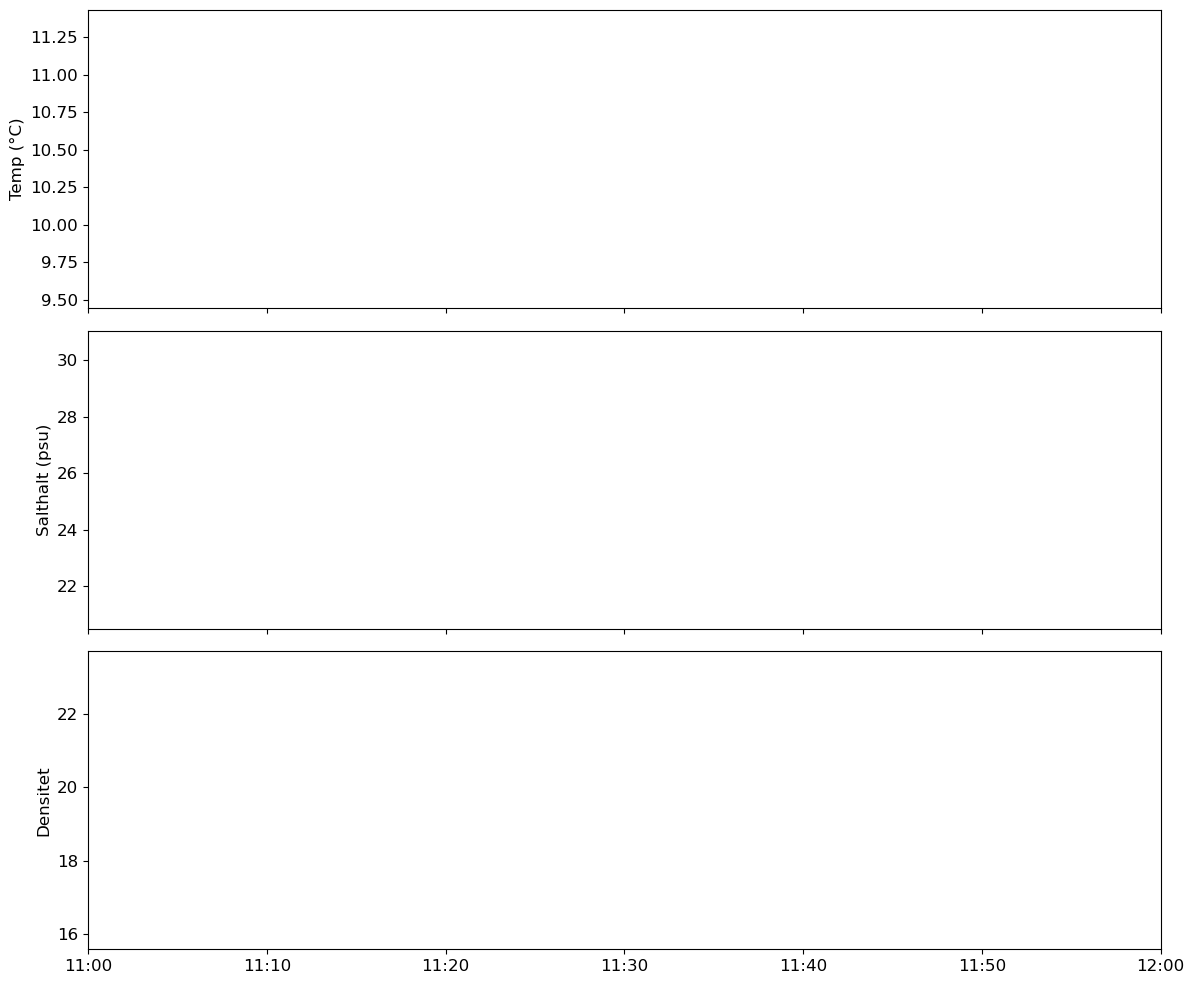

In [10]:
import pandas as pd
import matplotlib.dates as mdates

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axs[0].plot(df_all['datetime'], df_all['CT'],      color='tab:red')
axs[1].plot(df_all['datetime'], df_all['SA'],      color='tab:blue')
axs[2].plot(df_all['datetime'], df_all['sigma0'],  color='tab:green')

axs[0].set_ylabel('Temp (°C)')
axs[1].set_ylabel('Salthalt (psu)')
axs[2].set_ylabel('Densitet')

# ――― zoom window (05-08 11:00 → 12:00) ―――
start = pd.Timestamp('2025-05-08 11:00')
end   = pd.Timestamp('2025-05-08 12:00')
for ax in axs:
    ax.set_xlim(start, end)
#    ax.set_ylim(10.3,11.8)

# optional: nicer hour labels
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()


Now I want to compute the Bouyancy gradient

In [11]:
# Option 1 of computing bouy grad

from pyproj import Geod
from scipy.interpolate import interp1d

g    = 9.81          # gravity (m s-2)
rho0 = 1025.0        # reference density (kg m-3)

# distance along track (m)
geod = Geod(ellps="WGS84")
lon  = df_all["Longitude"].to_numpy()
lat  = df_all["Latitude"].to_numpy()
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))      # 0, 730 m, 1490 m, …

# buoyancy b = g (1 – ρ/ρ₀)  with ρ = σθ + 1000
rho = df_all["sigma0"].to_numpy() + 1000.0
b   = g * (1 - rho / rho0)

# regular 500 m distance grid
d_reg = np.arange(0, dist[-1], 1000.0)

# interpolate buoyancy onto this grid
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# constant-spacing gradient (Δx = 500 m)
dbdx_reg = np.gradient(b_reg, 500.0)          # s-2 on the regular grid

# map the regular-grid gradient back onto the original rows
df_all["buoy_grad"] = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)


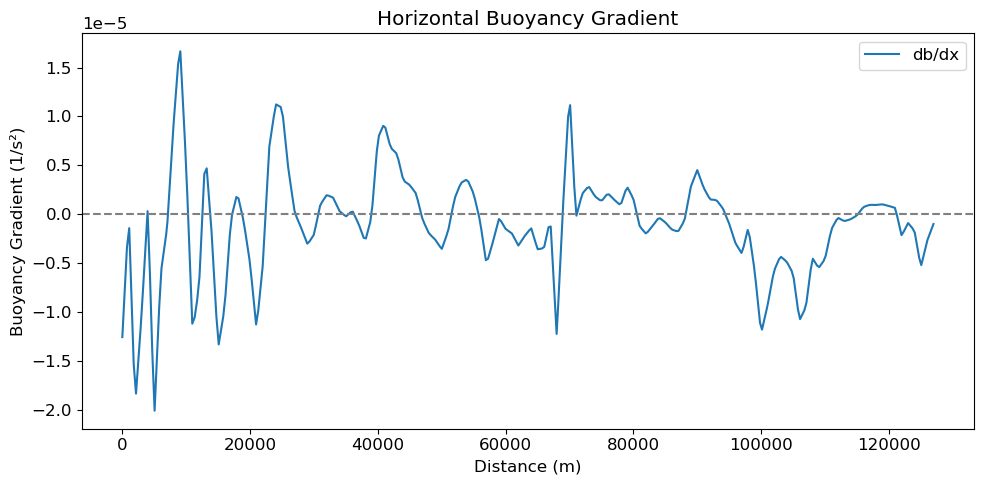

In [12]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(dist, df_all['buoy_grad'], label=f'db/dx')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# Option 2 of computing the bouy grad
from pyproj import Geod
from scipy.interpolate import interp1d

g =  9.81
rho0 = 1025.0

# get distance along track (m)
geod = Geod(ellps="WGS84")
lon, lat = df_all["Longitude"].to_numpy(), df_all["Latitude"].to_numpy()
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))

# buoyancy 
rho = df_all["sigma0"].to_numpy() + 1000.0
b   = g * (1 - rho / rho0)

# regular 500 m grid
d_reg = np.arange(0, dist[-1], 500.0)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# finite-difference gradient then rolling mean 
dbdx_reg = np.gradient(b_reg, 500.0)                 # raw gradient
dbdx_smooth = (pd.Series(dbdx_reg)
               .rolling(5, center=True)              # 5-point window (≈2 km)
               .mean()
               .to_numpy())

#  map back to original rows
df_all["buoy_grad"] = np.interp(dist, d_reg, dbdx_smooth,
                                left=np.nan, right=np.nan)


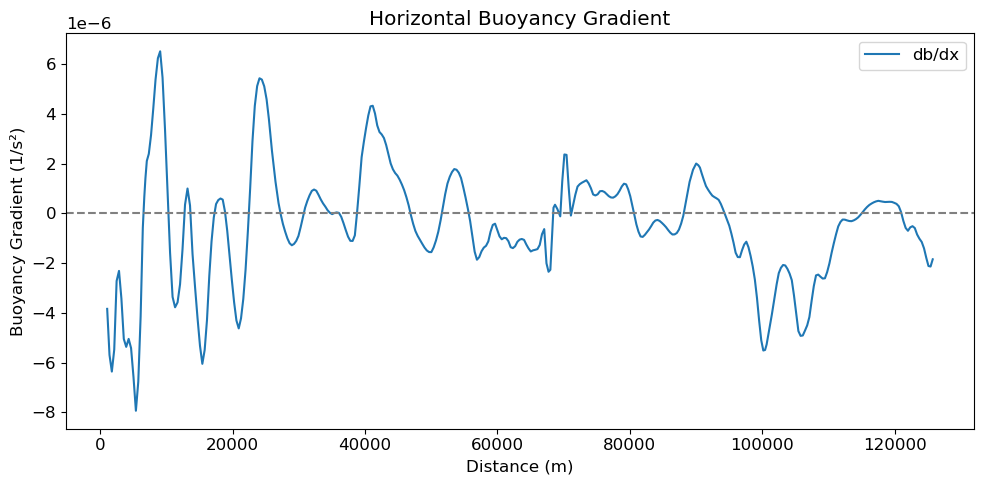

In [39]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(dist, df_all['buoy_grad'], label=f'db/dx')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient')
plt.legend()
plt.tight_layout()
plt.show()

But might be better to do for each dataset separatly since its now interpolating in between the datasets, where there are no measurments

Open the weather data to compute the Ekman bouyancy flux

In [13]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [14]:
# # first few rows
# print(df_wind.head())        # or df_wind.sample(5) for random rows
# print(df_pos.head())

# column names
print(df_wind.columns)
print(df_pos.columns)

# # quick summary of types / non-null counts
# df_wind.info()
# df_pos.info()

Index(['ts', 'airtemp', 'humidity', 'airpressure', 'windspeed', 'winddir'], dtype='object')
Index(['ts', 'latitude', 'longitude', 'gndspeed', 'gndcourse', 'gps_quality',
       'nbused', 'hdop'],
      dtype='object')


In [15]:
print(df_wind['windspeed'].describe())   # should be in the 0–25 m s⁻¹ range


count    3258.000000
mean        2.708379
std         3.040649
min         0.000000
25%         0.600000
50%         1.400000
75%         3.600000
max        15.800000
Name: windspeed, dtype: float64


In [16]:
df_wind['ts'] = pd.to_datetime(df_wind['ts'])
df_pos ['ts'] = pd.to_datetime(df_pos ['ts'])


In [17]:
df_wind['ts'] = df_wind['ts'].dt.round('1min')
df_pos ['ts'] = df_pos ['ts'].dt.round('1min')

df = pd.merge_asof(df_pos.sort_values('ts'), df_wind.sort_values('ts'), on='ts',
                   direction='nearest', tolerance=pd.Timedelta('1min')).dropna(subset=['windspeed'])        # keep rows with wind data


<Axes: >

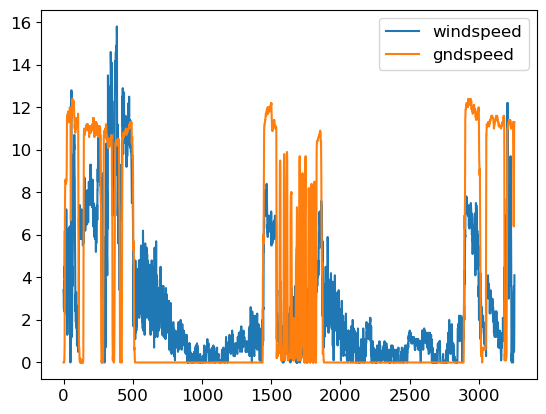

In [18]:
# quick sanity: compare wind to ship speed
df[['windspeed', 'gndspeed']].plot()


In [19]:
# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df['airtemp'   ].to_numpy(float)           # °C
P   = df['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df['humidity'  ].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df['windspeed'].to_numpy(float)          # m s⁻¹
theta = np.deg2rad(df['winddir'].to_numpy(float))

u = -U * np.sin(theta)      # eastward (+ = toward east)
v = -U * np.cos(theta)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df['tau']   = tau
df['tau_x'] = tau_x
df['tau_y'] = tau_y

# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df[['ts', 'latitude', 'longitude', 'tau', 'tau_x', 'tau_y']].head())

                   ts   latitude  longitude       tau     tau_x     tau_y
0 2025-05-06 07:00:00  57.686355  11.893357  0.021691 -0.004510 -0.021217
1 2025-05-06 07:01:00  57.686355  11.893356  0.020434 -0.004597 -0.019910
2 2025-05-06 07:02:00  57.686355  11.893358  0.018033  0.008466 -0.015922
3 2025-05-06 07:03:00  57.686355  11.893356  0.011727 -0.001429 -0.011640
4 2025-05-06 07:04:00  57.686363  11.893342  0.027085  0.001889 -0.027019


Compute corilois and then EBF

In [20]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.5e} s⁻¹")


Coriolis parameter at 57°: 1.22313e-04 s⁻¹


In [21]:
# prepare the two source tables
bx   = df_all[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      # 1 007 rows
tau  = df[['ts','tau']].rename(columns={'ts':'datetime'})  # 3 258 rows

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')


# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
alpha = 10**-4
g = 9.82
tau_const = 0.02

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * tau_const) / (f)) * ((Cp) / (alpha * g))

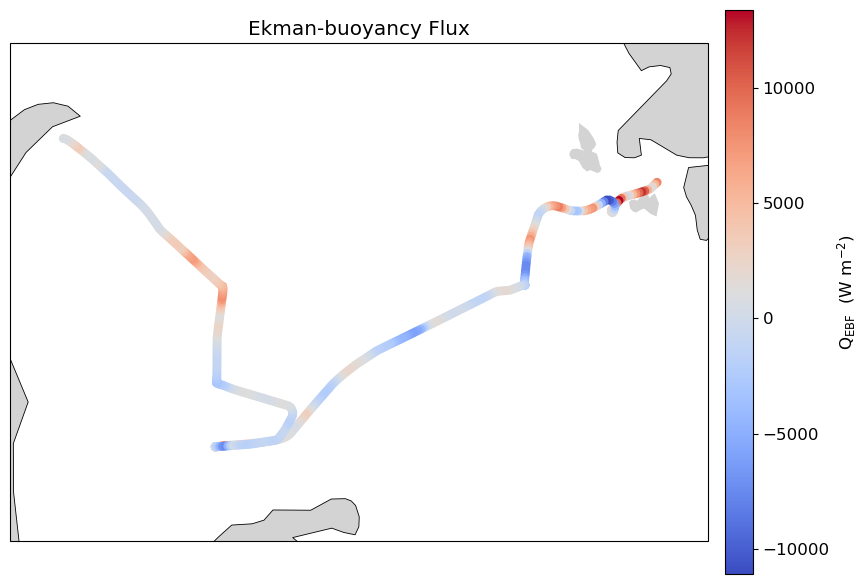

In [22]:
# 3.  scatter along the transect
fig = plt.figure(figsize=(9,6))
ax  = plt.axes(projection=ccrs.Mercator())
ax.set_extent([combo['Longitude'].min()-0.1, combo['Longitude'].max()+0.1, combo['Latitude' ].min()-0.1, 
               combo['Latitude' ].max()+0.1], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, lw=0.6)
ax.add_feature(cfeature.LAND,     facecolor='lightgrey')

sc = ax.scatter(combo['Longitude'], combo['Latitude'],
                c=combo['Q_EBF'],
                cmap='coolwarm',  s=30,
                transform=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$  (W m$^{-2}$)')   # units

ax.set_title('Ekman-buoyancy Flux')
plt.tight_layout()
plt.show()

In [23]:
print(df['tau'])

0       0.021691
1       0.020434
2       0.018033
3       0.011727
4       0.027085
          ...   
3253    0.024210
3254    0.000467
3255    0.001195
3256    0.005398
3257    0.031403
Name: tau, Length: 3258, dtype: float64


In [25]:
print(df['tau_y'])

0      -0.021217
1      -0.019910
2      -0.015922
3      -0.011640
4      -0.027019
          ...   
3253   -0.002110
3254    0.000460
3255   -0.000543
3256   -0.001030
3257   -0.005453
Name: tau_y, Length: 3258, dtype: float64


In [53]:
print("τ  (Pa)          :", combo['tau'].abs().describe())
print("∂b/∂x (s⁻2 m⁻1) :", combo['buoy_grad'].abs().describe())
print("f  (s⁻1)         :", f)


τ  (Pa)          : count    468.000000
mean       0.137279
std        0.096299
min        0.000000
25%        0.074487
50%        0.111344
75%        0.200124
max        0.467652
Name: tau, dtype: float64
∂b/∂x (s⁻2 m⁻1) : count    4.600000e+02
mean     1.732169e-06
std      1.534266e-06
min      1.767195e-08
25%      6.239993e-07
50%      1.309217e-06
75%      2.265712e-06
max      7.935522e-06
Name: buoy_grad, dtype: float64
f  (s⁻1)         : 0.00012231339297029653
